# Tutorial 04 - Edges
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/04_Edges.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Table of Contents  


- Canny Edge Detection
- Hough Transformation
- Harris Corner Detector

# Initilization

As always let's import useful libraries, first.

In [ ]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt

We will work with images today. So let's download some with `curl` (the same sources as in `02_OpenCV.ipynb`).

In [ ]:
!curl -o "cat.jpg" "https://placekitten.com/256/256"
!curl -o "gogh.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Vincent_van_Gogh_-_National_Gallery_of_Art.JPG/367px-Vincent_van_Gogh_-_National_Gallery_of_Art.JPG"
!curl -o "einstein.jpg" "https://www.cns.nyu.edu/~lcv/ssim/index_files/image003.jpg"
# !curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_w_d.jpg"
!curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_c_d.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7235  100  7235    0     0  31320      0 --:--:-- --:--:-- --:--:-- 31456
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84904  100 84904    0     0   760k      0 --:--:-- --:--:-- --:--:--  760k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16025  100 16025    0     0  75589      0 --:--:-- --:--:-- --:--:-- 75589
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56921    0 56921    0     0   253k      0 --:--:-- --:--:-- --:--:--  253k


Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab.patches import cv2_imshow
else:
  print('Not running on CoLab')
  def cv2_imshow(img):
      """A replacement for cv2.imshow() for use in Jupyter notebooks.

        Args:
          img : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
      """
      cv2.imshow('image', img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

Running on CoLab


# Practice with linear filters

Image filters in OpenCV are applied with `cv2.filter2D(img,-1,kernel)`, where the image and the kernel are numpy arrays.
You can define a custom kernel by defining a numpy array:  
```
np.array([[0,0,0],
          [0,1,0],
          [0,0,0]])
```


## ⌨️ Try it yourself: What results do you expect?

What results do you expect if you apply the following kernels:
1. \begin{pmatrix}
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0 \end{pmatrix}

1. \begin{pmatrix}
0 & 0 & 0\\
0 & 0 & 1\\
0 & 0 & 0 \end{pmatrix}

1. \begin{pmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1 \end{pmatrix}

1. Furthermore, what do you expect if you filter an image with:
  \begin{pmatrix}
      0 & 0 & 0\\
      0 & 2 & 0\\
      0 & 0 & 0 \end{pmatrix}
  and subtract another filtered image from the result. The second image is filtered with:    
  \begin{pmatrix}
      \frac{1}{9}  & \frac{1}{9}  & \frac{1}{9} \\
      \frac{1}{9}  & \frac{1}{9}  & \frac{1}{9} \\
      \frac{1}{9}  & \frac{1}{9}  & \frac{1}{9} \end{pmatrix} 

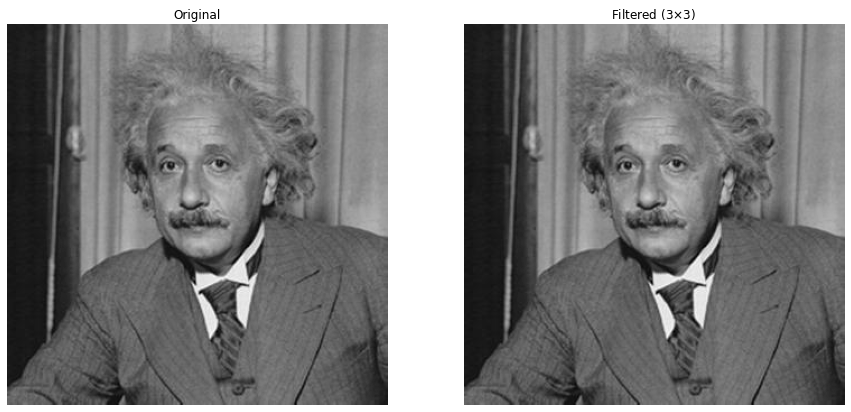

In [ ]:
img = cv2.imread('einstein.jpg')[:,:,1].astype(np.float32)

# define your costum kernel below
kernel = np.array([[0,0,0],
                   [0,1,0],
                   [0,0,0]])
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(img, cmap='gray'),plt.title('Original')
plt.subplot(122),imshow((dst), cmap='gray'),plt.title(r'Filtered ({}$\times${})'.format(*kernel.shape[:2]))
plt.show()

# Canny Edge Detection

Probably the most widely used edge detector in computer vision.
Canny showed that first derivative of Gaussian closely approximates the operator that optimizes the product of signal-to-noise ratio and localization.

Scientific Paper: [J. Canny, A Computational Approach To Edge Detection, IEEE Trans. Pattern Analysis and Machine Intelligence, 8:679-714, 1986.](https://ieeexplore.ieee.org/document/4767851?isnumber=4767846&arnumber=4767851&count=16&index=4)


## OpenCV's Canny implementation

Let's first look at the implementation available with OpenCV. 
```
cv2.Canny(dx, dy, threshold1, threshold2)
```
The `Canny` function takes the derivatives in x and y and two hysteresis thresholds as input.
Let's also look at the magnitude and the orientation.

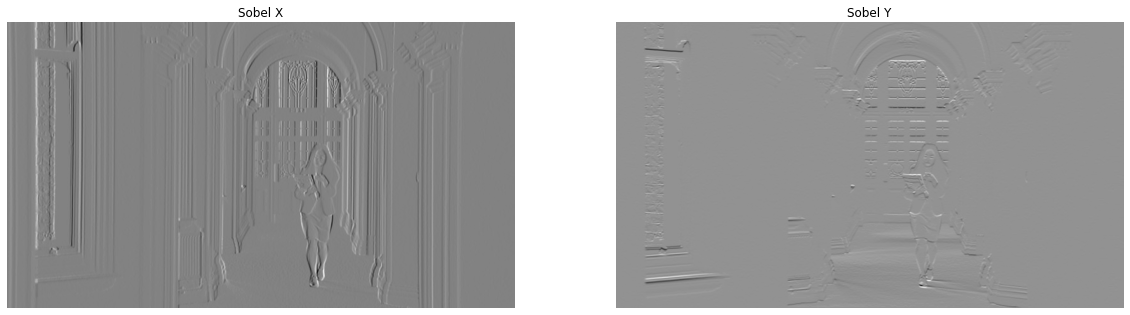

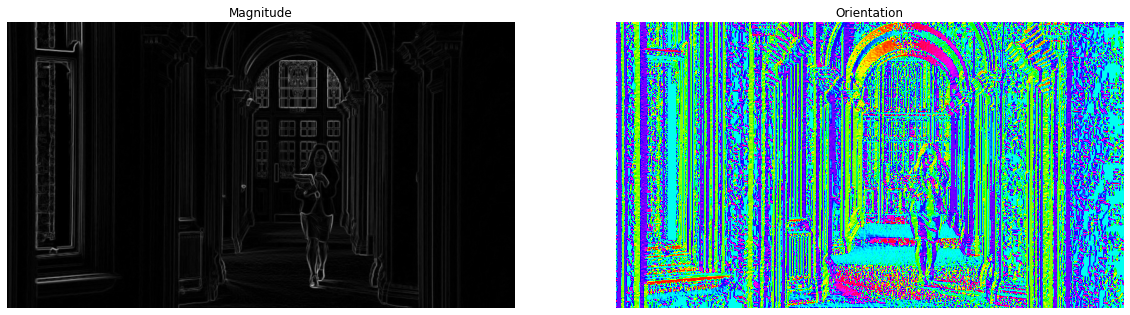

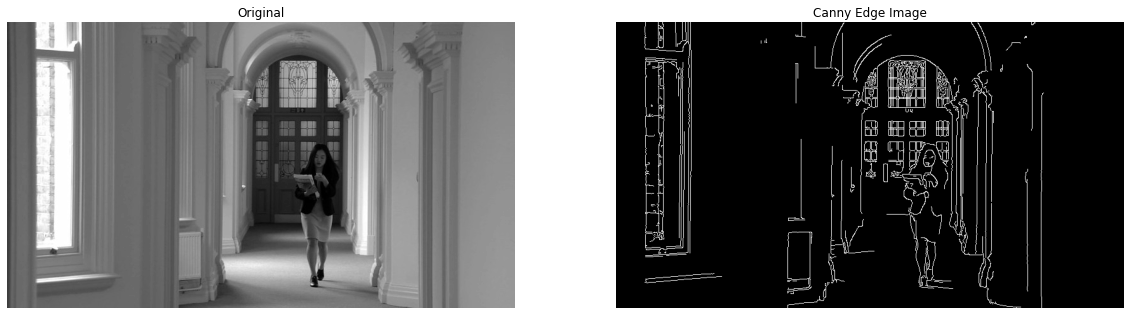

In [ ]:
img = cv2.imread('woman.jpg',0)

gsize = (15,15)
#img = cv2.GaussianBlur(img, gsize, 3)

ksize = 3
#edges = cv2.Canny(img,100,200,apertureSize=ksize)

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1),imshow(sobelx,cmap = 'gray'), plt.title('Sobel X')
plt.subplot(1,2,2),imshow(sobely,cmap = 'gray'), plt.title('Sobel Y')
plt.show()

mag = np.sqrt( sobelx**2 + sobely**2 )
theta = np.arctan2(sobelx, sobely)

plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(mag,cmap = 'gray'), plt.title('Magnitude')
plt.subplot(122), imshow(theta,cmap='hsv'), plt.title('Orientation')
plt.show()

# OpenCVs implementation using the gradients in x and y
edges = cv2.Canny(sobelx.astype(np.int16), sobely.astype(np.int16), 0.1*np.amax(mag),0.2*np.amax(mag))

plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(img,cmap = 'gray'), plt.title('Original')
plt.subplot(122), imshow(edges,cmap = 'gray'), plt.title('Canny Edge Image')
plt.show()

# Hough Transformation

Hough Transform is a voting technique that finds the parameters of lines in an image. 
The algorithm starts with a corner or edge detection for regular images. 
So it needs a binary/grey image, where 0s are non-edges and >0 are edges.


## OpenCV's Hough implementation

Let's first look at the implementation available with OpenCV. 
We can reuse the edge image (`edges`) that we computed before.
The function call is
```
cv2.HoughLines( edges, rho, theta, threshold )
```
and the parameters are the edge image, the distance resolution of the accumulator for $d$ in pixels and the angle $\theta$ in radians, and the accumulator threshold.

Line  0: d= 74.00, theta= 90
Line  1: d= 67.00, theta= 90
Line  2: d= 46.00, theta= 90
Line  3: d=118.00, theta= 90
Line  4: d=114.00, theta= 90
Line  5: d=669.00, theta= 90
Line  6: d= 96.00, theta= 91
Line  7: d=582.00, theta= 90
Line  8: d=104.00, theta= 90
Line  9: d=591.00, theta= 90


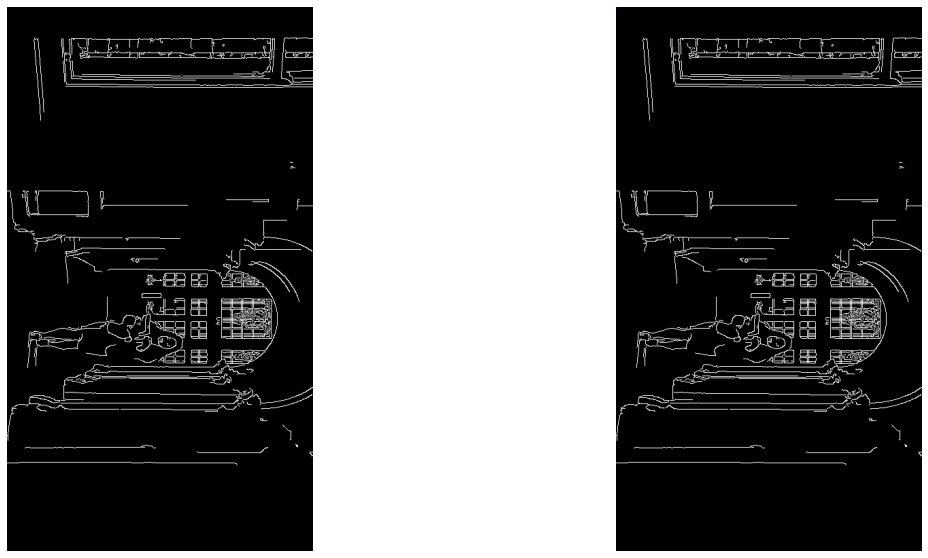

In [ ]:
image = cv2.rotate( edges, cv2.ROTATE_90_CLOCKWISE ) # reuse edges image

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(image, 1, np.pi / 180, 150)

if lines is not None:
    for i in range(0, len(lines)):
        d = lines[i][0][0]
        theta = lines[i][0][1]

        print("Line {:2d}: d={:6.2f}, theta={:3.0f}".format(i, d, np.rad2deg(theta)))

        # Plot the lines
        # Your TODO!
        pt1 = None
        pt2 = None
        cv2.line( cdst, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)

# optionally, we can use the probabilistic hough transform:
#linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 150, None, 40, 20)

plt.figure(figsize=(20,10))
plt.subplot(121), imshow(image, cmap='gray')
plt.subplot(122),imshow(cdst) #"Detected Lines (Todo)", 
plt.show()


## Non-OpenCV implementation

To understand the algorithm better let's also look at an implementation without the builtin function of OpenCV. This implementation can also be found [online](https://github.com/alyssaq/hough_transform). 
Note: the implementation is only for illustration and there might be more efficient/robust ways of implementing it.

d=0.50, theta=-45


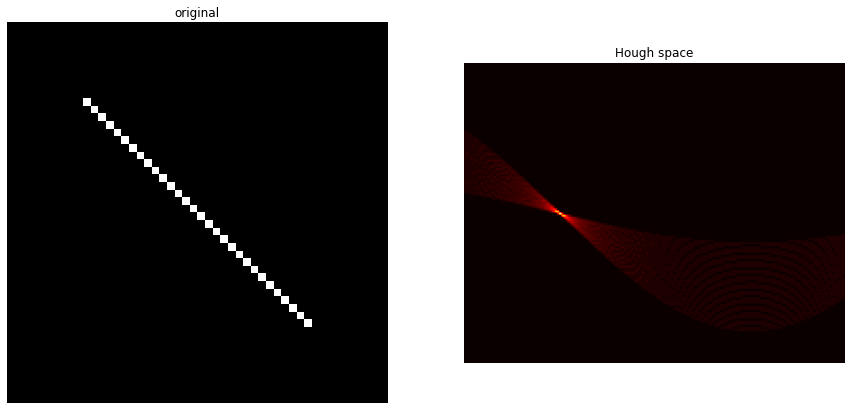

In [ ]:
def hough_line(img):
  # ds and Theta ranges
  thetas = np.deg2rad(np.arange(-90.0, 90.0))
  width, height = img.shape
  diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  # max_dist
  ds = np.linspace(-diag_len, diag_len, diag_len*2)

  # Cache some resuable values
  cos_t = np.cos(thetas)
  sin_t = np.sin(thetas)
  num_thetas = len(thetas)

  # Hough accumulator array of theta vs rho
  accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

  # Vote in the hough accumulator
  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]

    for t_idx in range(num_thetas):
      # Calculate rho. diag_len is added for a positive index
      d = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
      accumulator[d, t_idx] += 1

  return accumulator, thetas, ds

# Create binary image and call hough_line
image = np.zeros((50,50),dtype=np.int8)
#image[:, :] = np.eye(50)[::-1, :]# + np.eye(50)#[::-1, :]
image[10:40,10:40] = np.eye(30)
#image[25,10:40] = 1.0
accumulator, thetas, ds = hough_line(image)

# Easiest peak finding based on max votes
idx = np.argmax(accumulator)
d = ds[np.int(idx / accumulator.shape[1])]
theta = thetas[idx % accumulator.shape[1]]
print("d={:.2f}, theta={:.0f}".format(d, np.rad2deg(theta)))

# Plot the lines
# Your TODO!

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(image, cmap='gray'), plt.title( 'original' )
plt.subplot(122),imshow(accumulator, cmap='hot'), plt.title( 'Hough space' ) 
plt.show()

## ⌨️ Try it yourself: Plot the detected Hough lines.

Use the OpenCV or Non-OpenCV implementation of the Hough detector and plot the detected lines. Note that both should have the same parameters. So plotting should work for both implementations.

You can use the $m,b$ notation (which has problems with $\theta=0$) from the slides or you come up with a better way. 

Use OpenCV's `cv2.line` to directly plot into the image, or you use `plt.plot` to plot on the figure (resolution independent).

This image might help you:

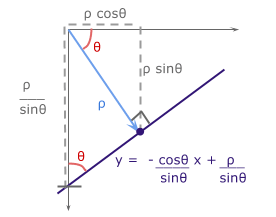

[Image Credits: Alyssa Quek](https://alyssaq.github.io/2014/understanding-hough-transform/)

Note that $\rho$ is $d$ in our implementation.

# Harris Corner Detector


## OpenCV's Harris implementation

Let's first look at the implementation available with OpenCV. 
```
cv2.cornerHarris(src, blockSize, ksize, k)
```
The `cornerHarris` function takes an image, the window size, a size parameter for the Sobel operator and k, the Harris detector free parameter, as input.
Let's apply it to our example image.

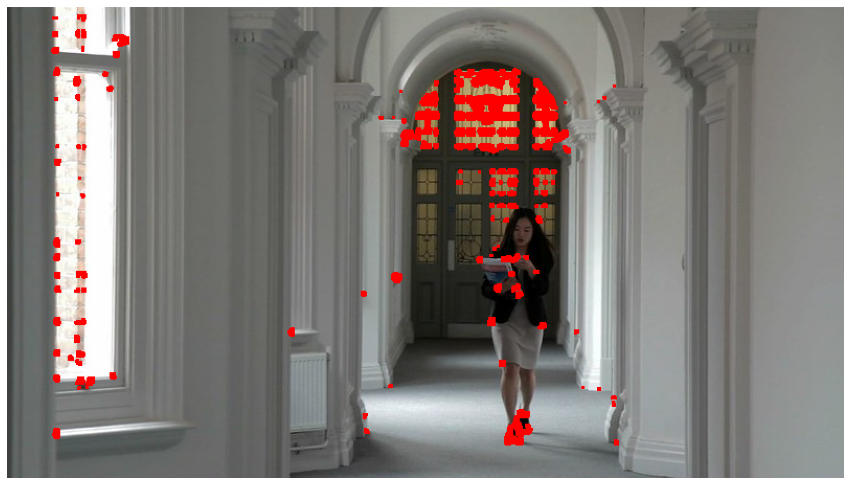

In [ ]:
filename = "woman.jpg"
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cv2.cornerHarris(gray.astype(np.float32),5,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]


plt.figure(figsize=(15,10))
imshow(img)
plt.show()


## Non-OpenCV implementation

To understand the algorithm better let's also look at an implementation without the builtin function of OpenCV. This implementation can also be found [online](https://github.com/hughesj919/HarrisCorner/blob/master/Corners.py). 
Note: the implementation is not very optimized and just for illustration. 
A local maximum suppression of R is not used.
Furthermore, it allows us to look at the computed R.

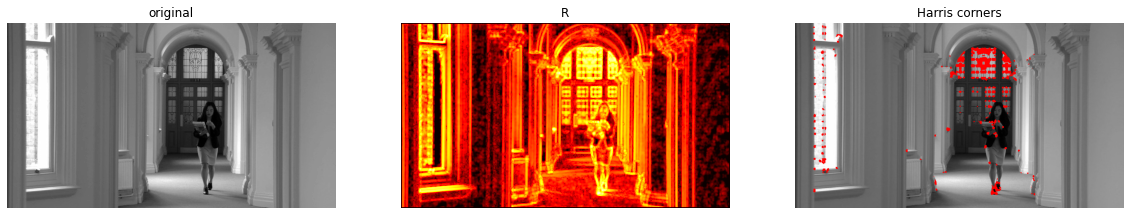

In [ ]:
def findCorners(img, window_size=5, k=0.04, thresh=10000 ):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = int(window_size/2)
    R = np.zeros_like(dx)

    #Loop through image and find our corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            R[y,x] = r # store in R matrix

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
                #print x, y, r
                cornerList.append([x, y, r])
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    return color_img, R, cornerList


finalImg, R, cornerList = findCorners(gray, 5, 0.05, thresh=10000000)

# plotting
plt.figure(figsize=(20,15))
plt.subplot(131), imshow(gray, cmap='gray'), plt.title( 'original' )
plt.subplot(132), imshow(np.log(abs(R)+1.0), cmap='hot'), plt.title( 'R' )
plt.subplot(133),imshow(finalImg), plt.title( 'Harris corners' ) 
plt.show()


